Main Idea :- We will check the dstribution of categorical variables for `TP,FP,TN & FN` datasets and see which specific values in FP & FN is my model failing on. 

#### Imports

In [3]:
!pip install catboost
from catboost import CatBoostClassifier

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy
%matplotlib inline

from sklearn import metrics

     |████████████████████████████████| 76.1 MB 1.1 MB/s 


In [4]:
# load data 
X_train_cb = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/X_train_catboost.csv').astype(str)
X_test_cb = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/X_test_catboost.csv').astype(str)

y_train = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/y_test.csv')

#### Training & Evaluation
Our best model was CatBoost which takes raw data as input. Therefore, We'll do error analysis using this model only.

In [5]:
# training
best_params = {'min_data_in_leaf': 50, 'depth': 10, 'od_wait': 10, 'l2_leaf_reg': 3, 'iterations': 500, 'subsample': 0.5, 'rsm': 0.3, 'learning_rate': 0.1,
                             'loss_function': 'Logloss','random_state':42,'eval_metric':'F1','custom_metric':'F1','one_hot_max_size':3}

model = CatBoostClassifier(cat_features = X_train_cb.columns.values,verbose=False,**best_params)
model.fit(X_train_cb,y_train.values.ravel())
y_pred = model.predict(X_test_cb)

In [6]:
# evaluation
def calculate_metrics(y_true,y_pred):
    '''
    Calculating F1-Score, AUC & Confusion-matrix
    ''' 

    f1 = metrics.f1_score(y_true,y_pred)

    y_true = y_true.values.ravel()
    # False-positives for test
    fp = np.nonzero((y_true==0) & (y_pred==1))[0]
    # False-negatives for test
    fn = np.nonzero((y_true==1) & (y_pred==0))[0]

    # True-positives for test
    tp = np.nonzero((y_true==1) & (y_pred==1))[0]
    # True-negatives for test
    tn = np.nonzero((y_true==0) & (y_pred==0))[0]

    ax = plt.subplot()
    sns.heatmap(metrics.confusion_matrix(y_true,y_pred),annot=True,fmt='d',cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Negative','Positive'])
    ax.yaxis.set_ticklabels(['Negative','Positive'])
    plt.show()
    print('='*130)

    return fp,fn,tp,tn



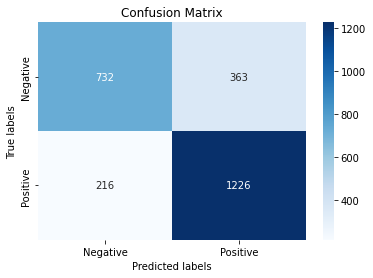

In [7]:
# evaluating fp & fn of test data
fp,fn,tp,tn = calculate_metrics(y_test,y_pred)

#### Error Analysis

Get most important deciding features from model

In [11]:
data = np.c_[X_test_cb.columns.values,model.feature_importances_]
fea_imp = pd.DataFrame(data,columns=['Column','Feature_imp'])
fea_imp = fea_imp.sort_values(by='Feature_imp',ascending=False).reset_index(drop=True)
fea_imp

,Column,Feature_imp
0,coupon,11.675163
1,CoffeeHouse,8.150649
2,occupation,7.86192
3,income,7.475649
4,Bar,6.4678
5,age,6.220843
6,maritalStatus,5.268394
7,expiration,5.098559
8,CarryAway,5.059906
9,education,4.88427


In the TOP-10 features we see that 
* how many times a person goes to a specific venue (like `Coffeehouse`,`Bar` etc.) are the most important including some user-context features like `age`, `income`,`Occupation` etc.    
* Most important feature however is the type of `Coupon` that is being presented to the user.    
Most of it correlates strongly with our EDA.

Analyzing False-positives

In [12]:
false_pos_pts = X_test_cb.iloc[fp,:]
true_pos_pts = X_test_cb.iloc[tp,:]

In [13]:
def freq_plotter(nrows, ncols,figsize,col_to_plot,df1,df2,label):
    '''
    Helper function to print countplots / frequency-distribution for cols of FP & TP
    '''
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)  

    temp1 = df1[col_to_plot].value_counts(normalize=True)
    temp2 = df2[col_to_plot].value_counts(normalize=True)

    sns.barplot(x=temp1.values,y=temp1.index,ax=ax[0])
    ax[0].set_xlabel('%age')
    if label=='pos':
        ax[0].set_title('Frequency distribution of {} for FP'.format(col_to_plot))
    else:
        ax[0].set_title('Frequency distribution of {} for FN'.format(col_to_plot))

    sns.barplot(x=temp2.values,y=temp2.index,ax=ax[1])
    ax[1].set_xlabel('%age')
    if label=='pos':
        ax[1].set_title('Frequency distribution of {} for TP'.format(col_to_plot))
    else:
        ax[1].set_title('Frequency distribution of {} for TN'.format(col_to_plot))
    
    plt.tight_layout()
    plt.show()

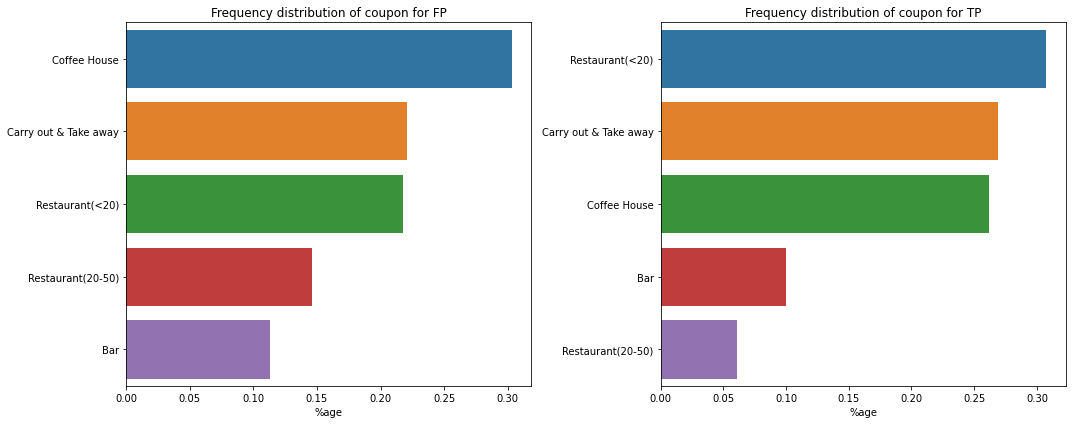

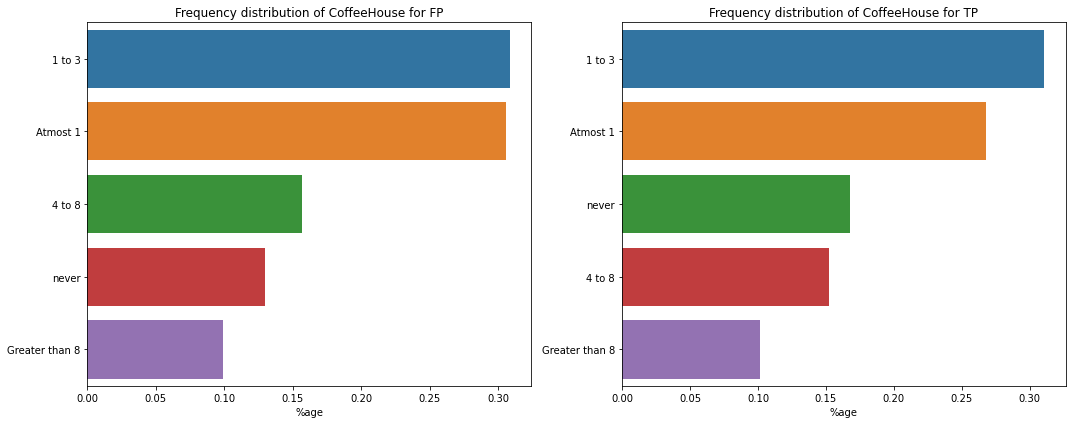

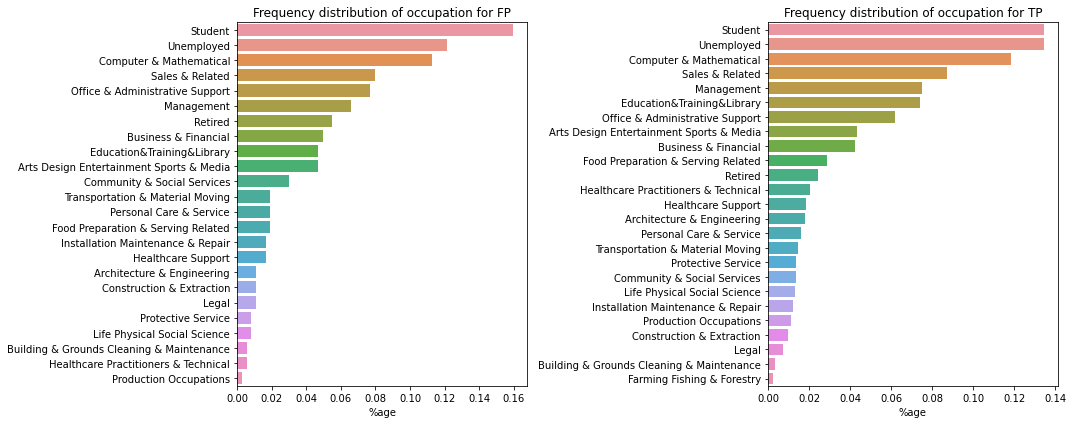

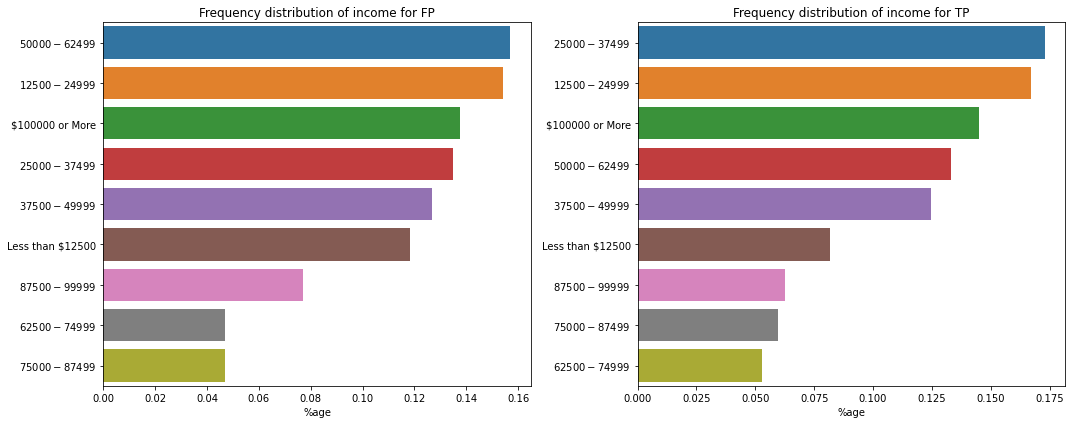

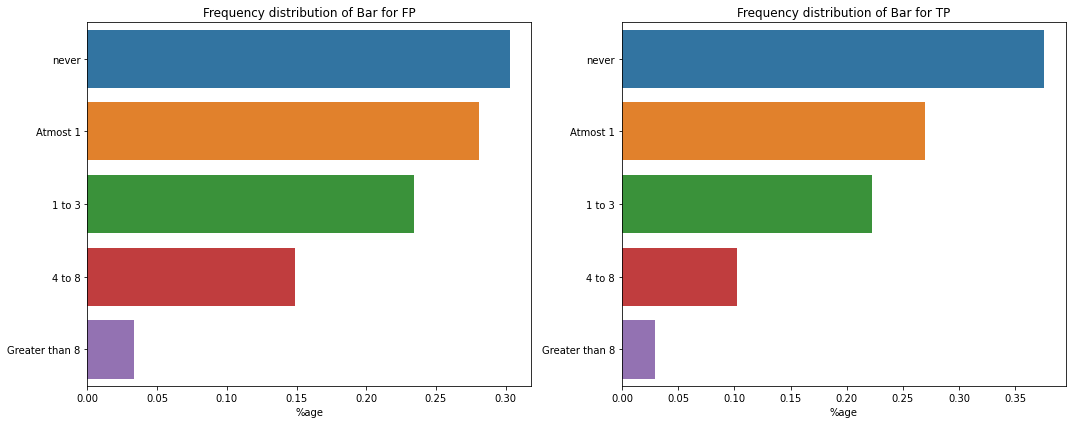

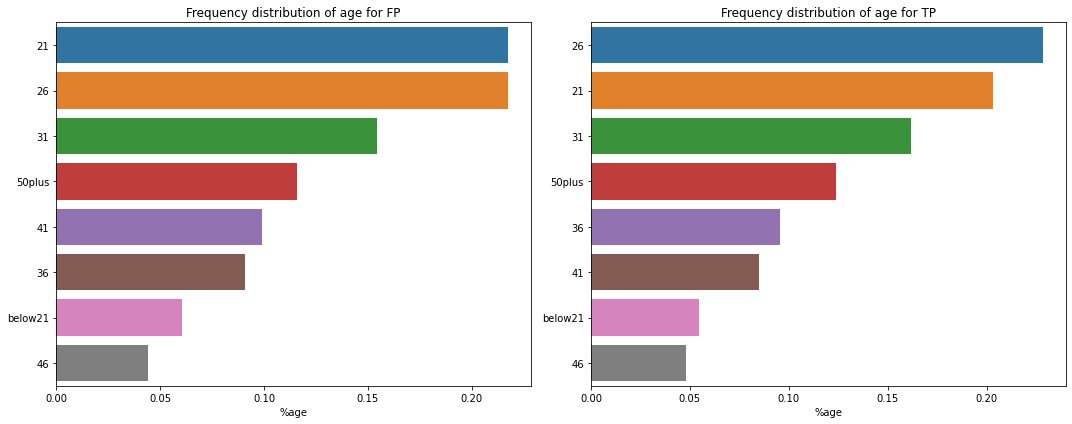

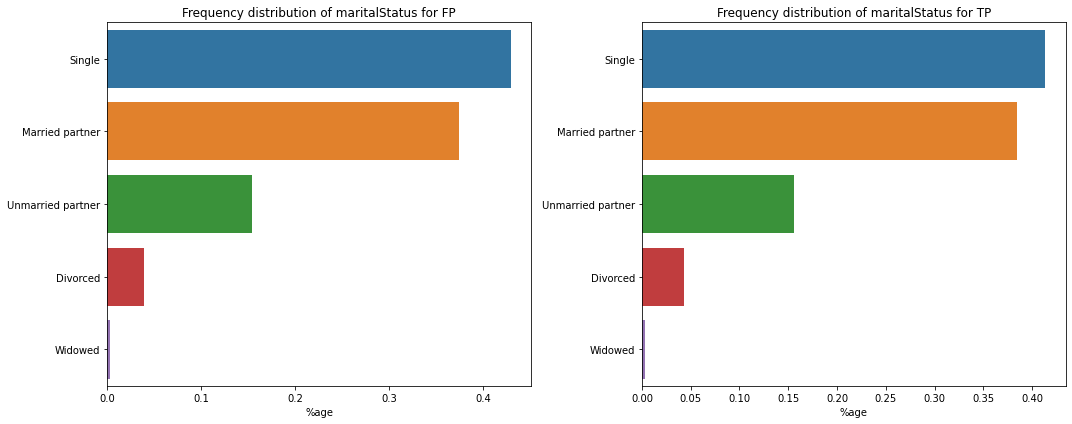

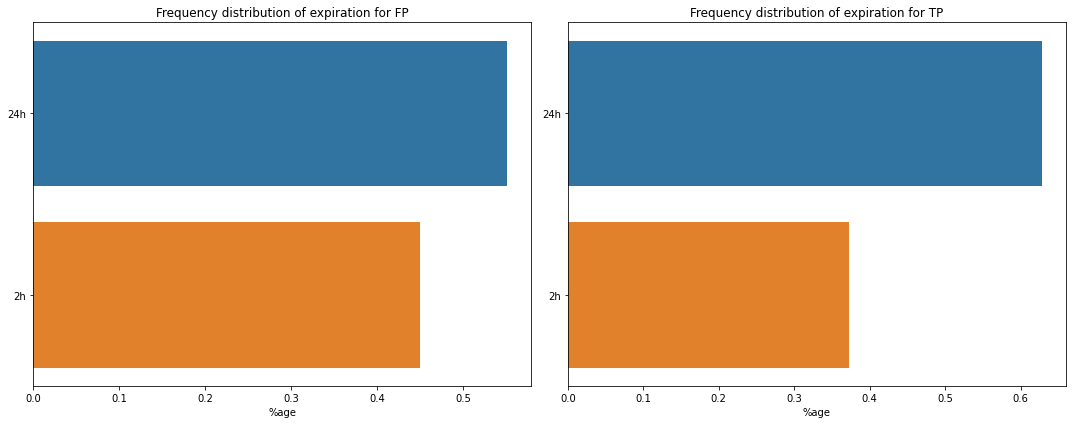

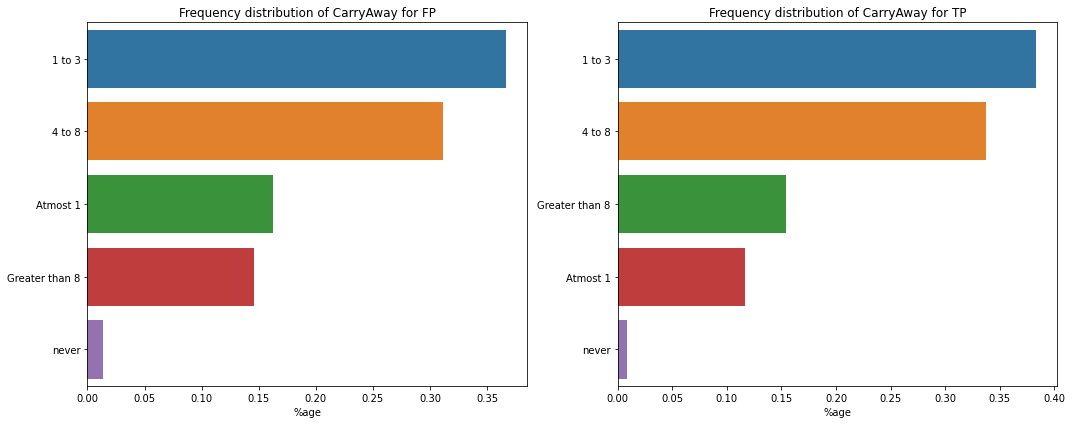

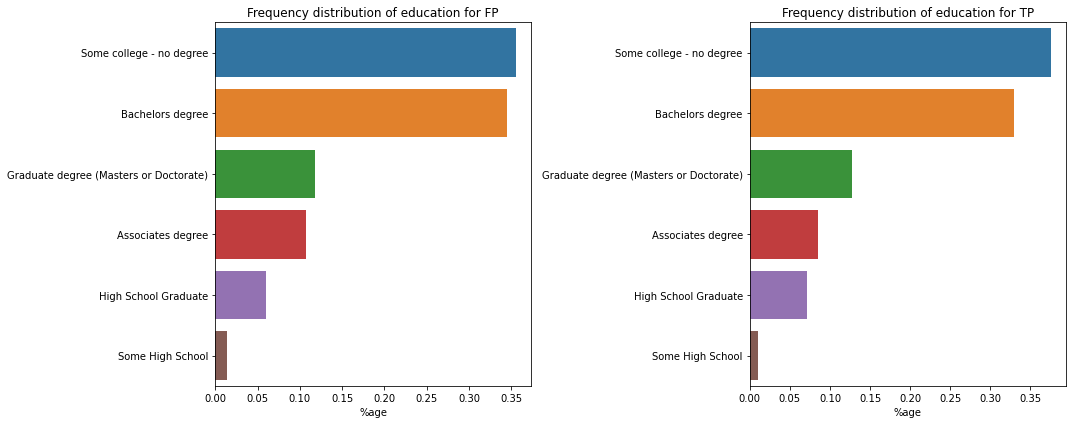

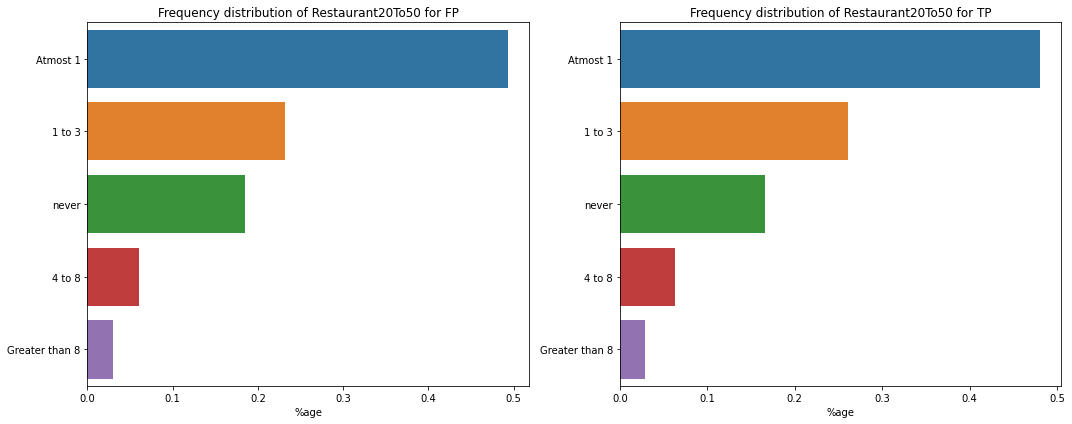

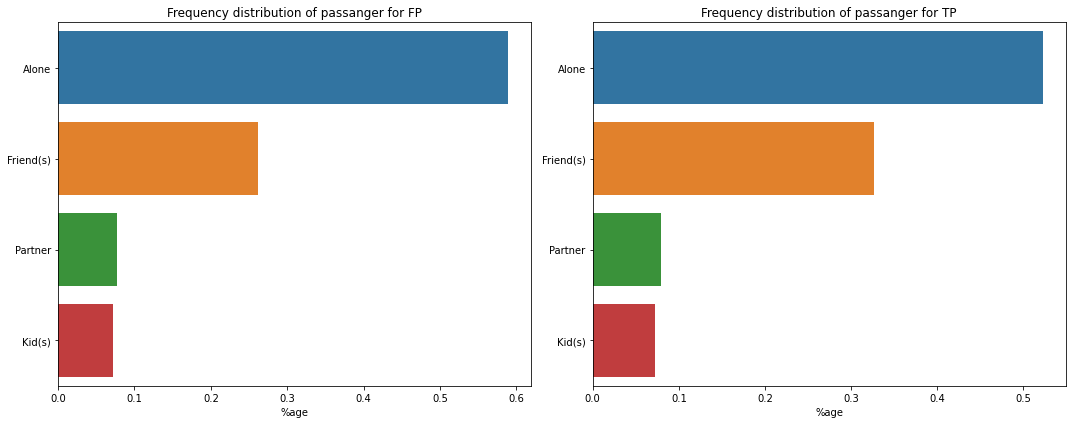

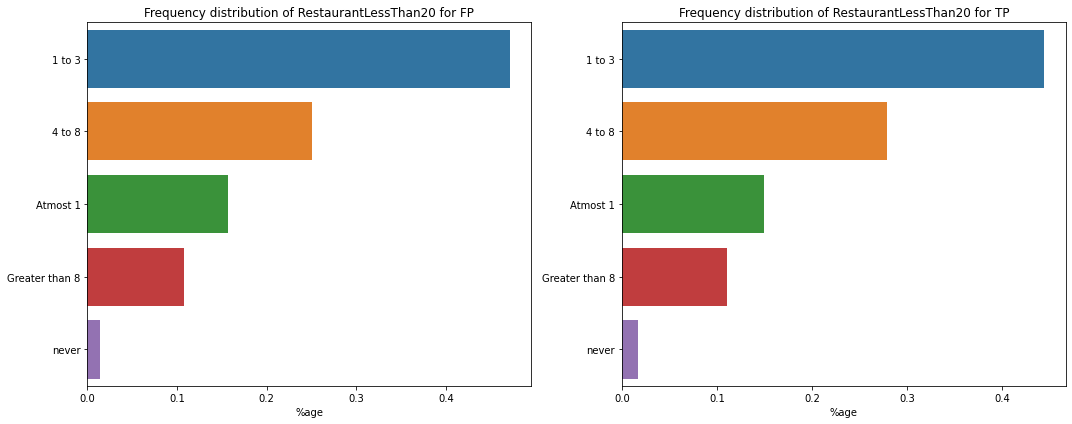

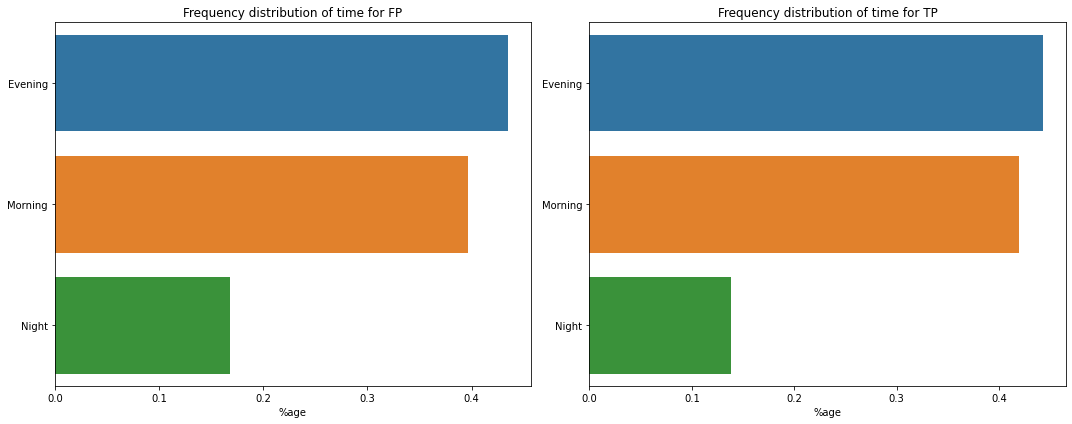

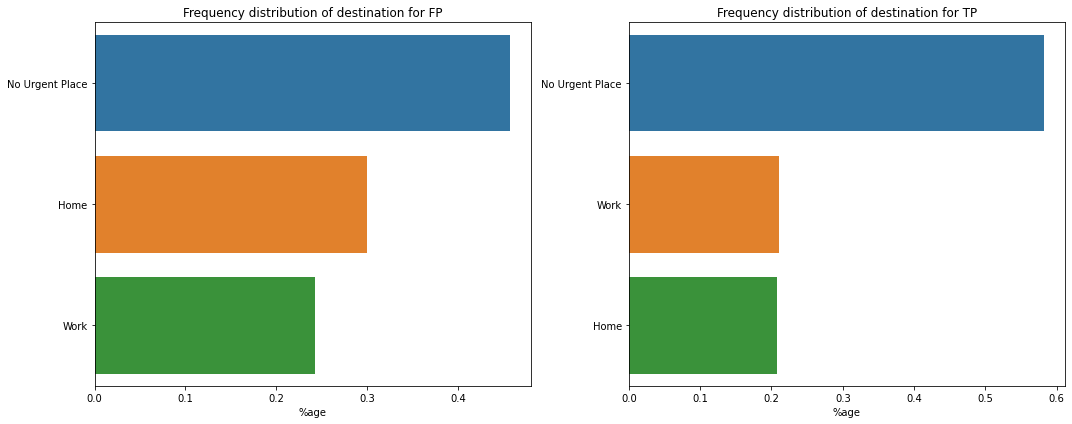

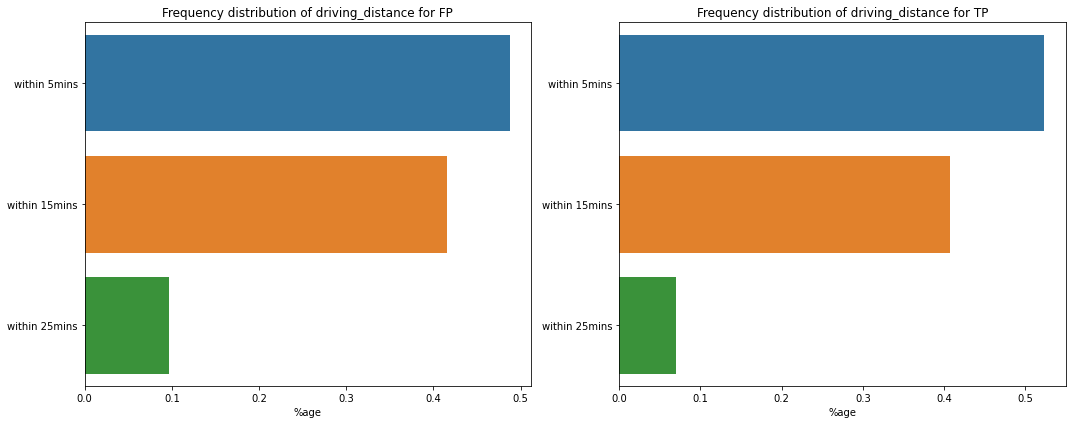

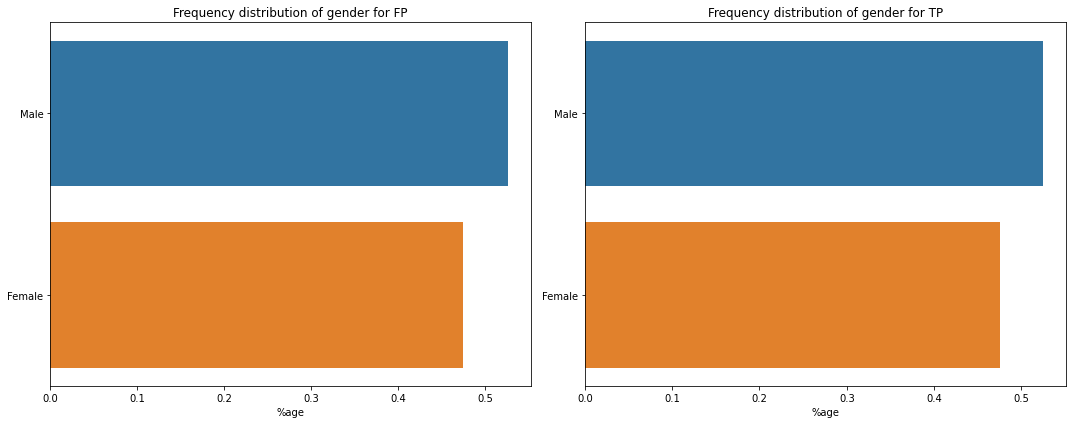

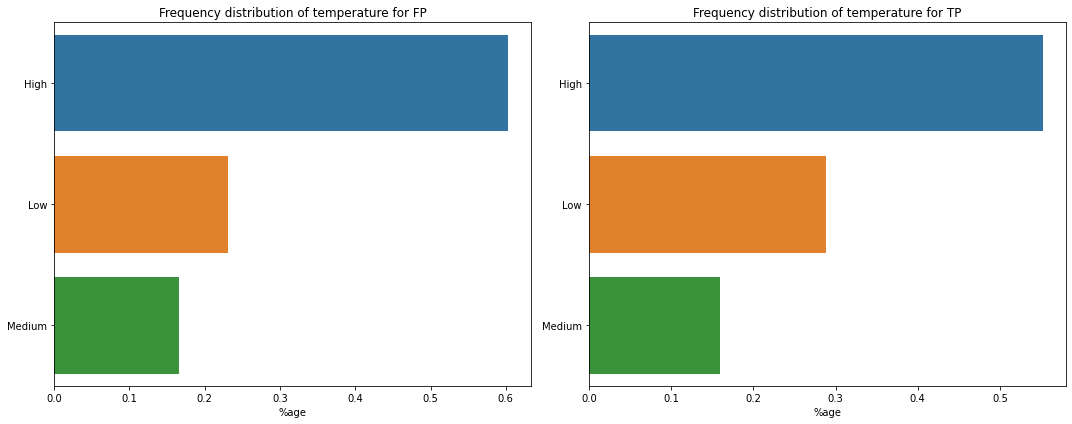

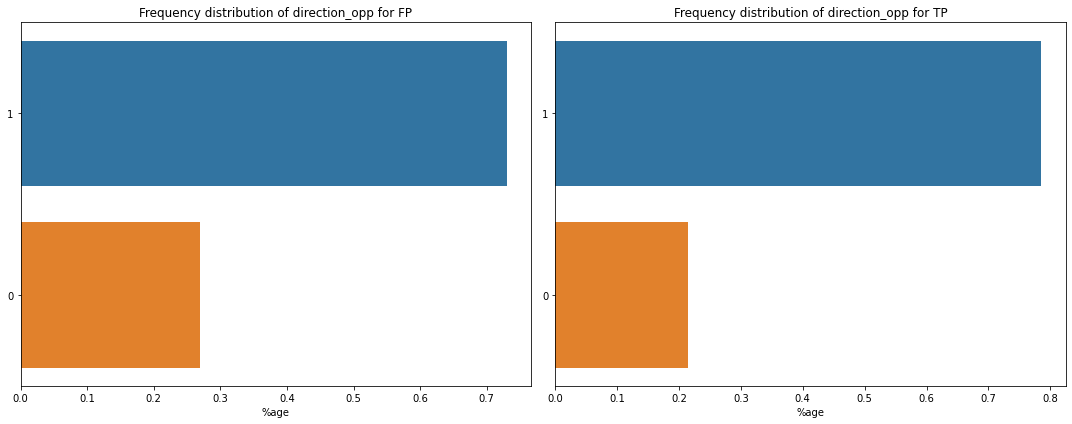

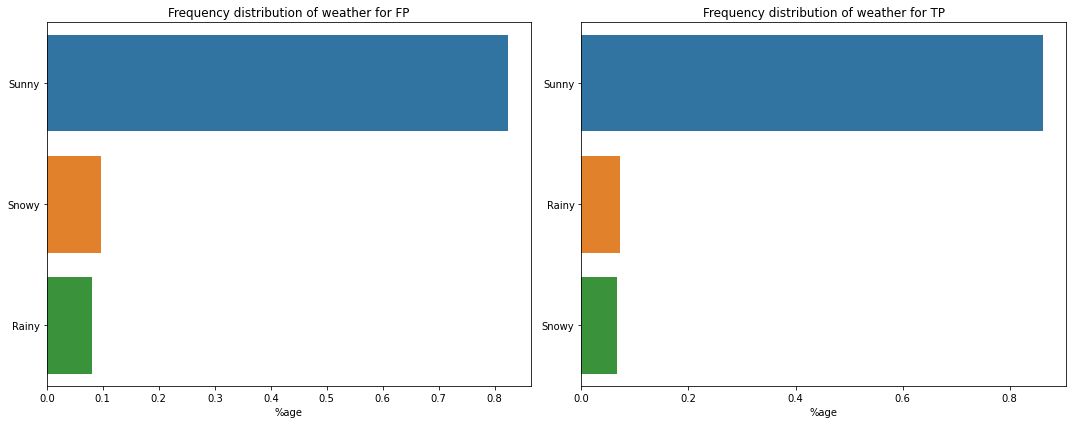

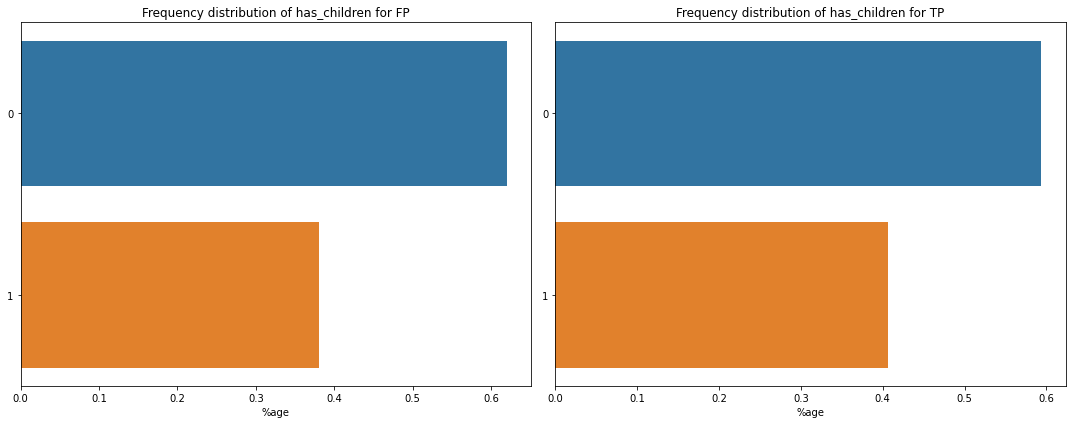

In [14]:

nrows = 1  
ncols = 2
figsize = (15,6)

for col in fea_imp.Column.values:
    freq_plotter(nrows,ncols,figsize,col,false_pos_pts,true_pos_pts,'pos')
    print('='*130)

Observations
* A lot of False positives on Coffeehouse coupons
* Also more FP on points where user have home as destination and have Income-Range of \$50000-\$62499

Analyzing False-Negatives

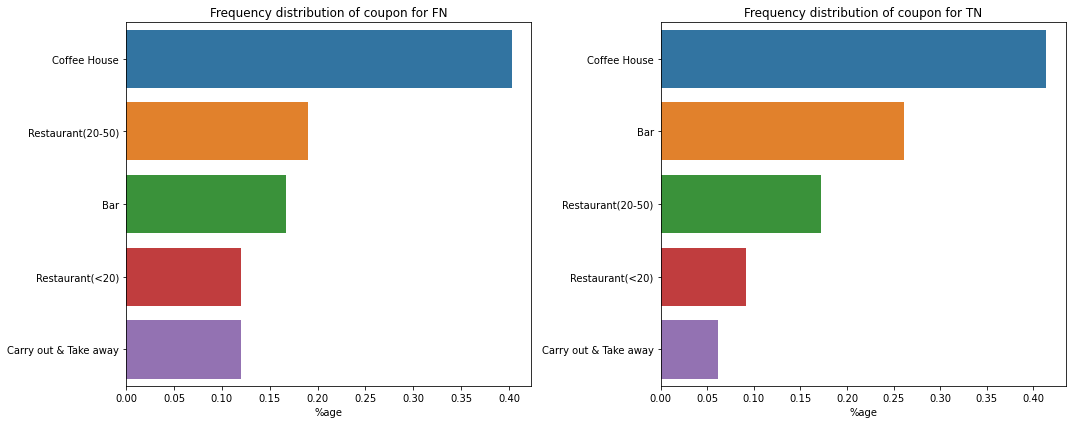

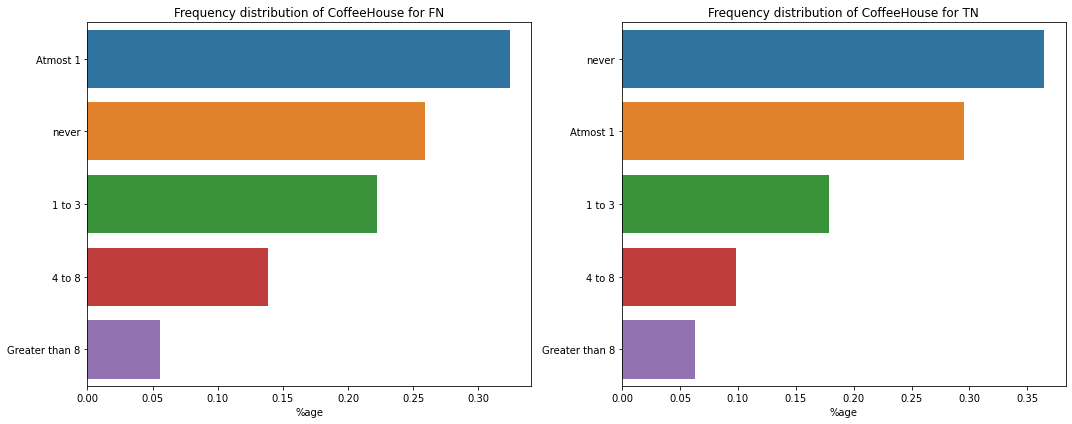

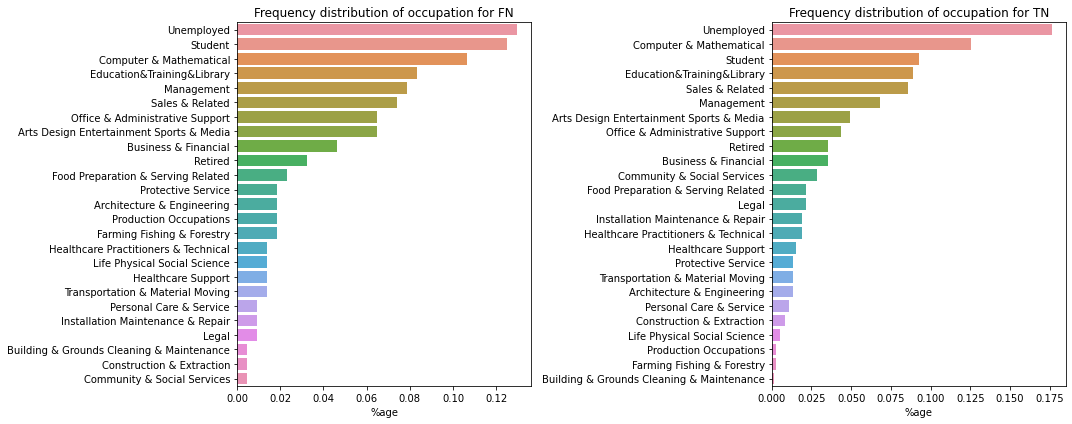

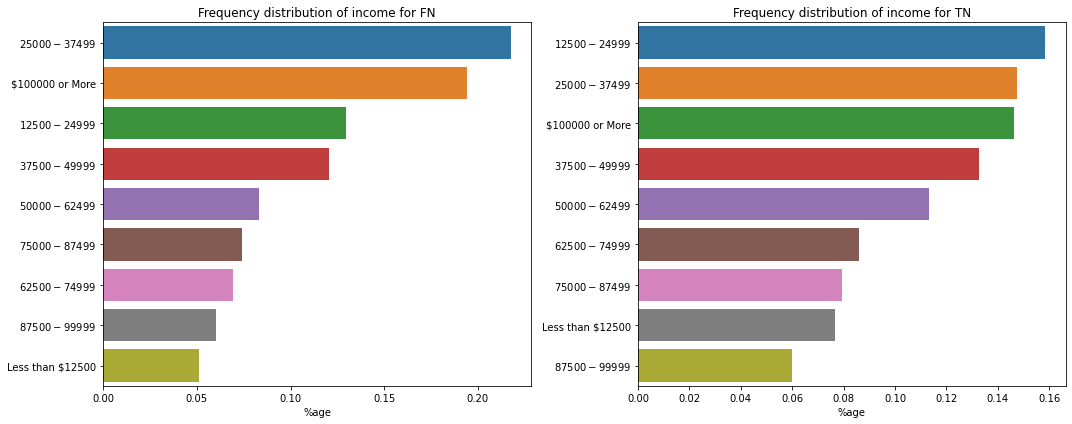

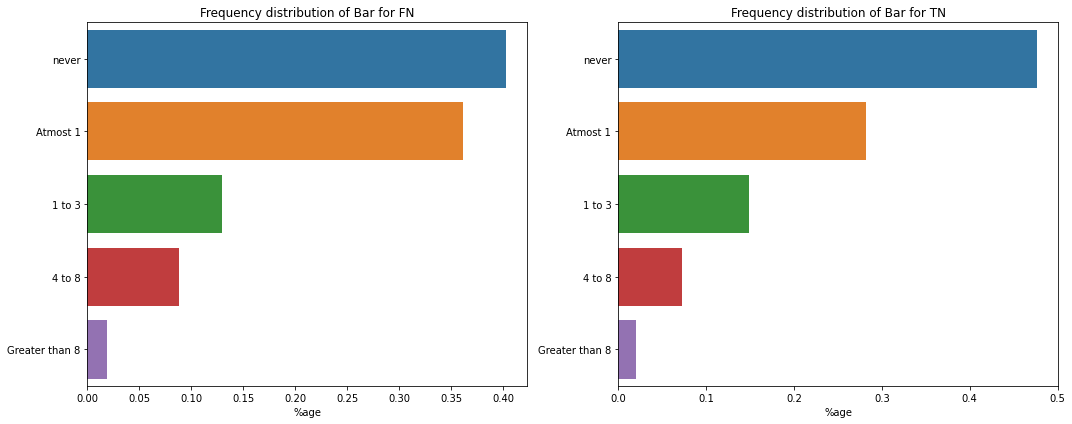

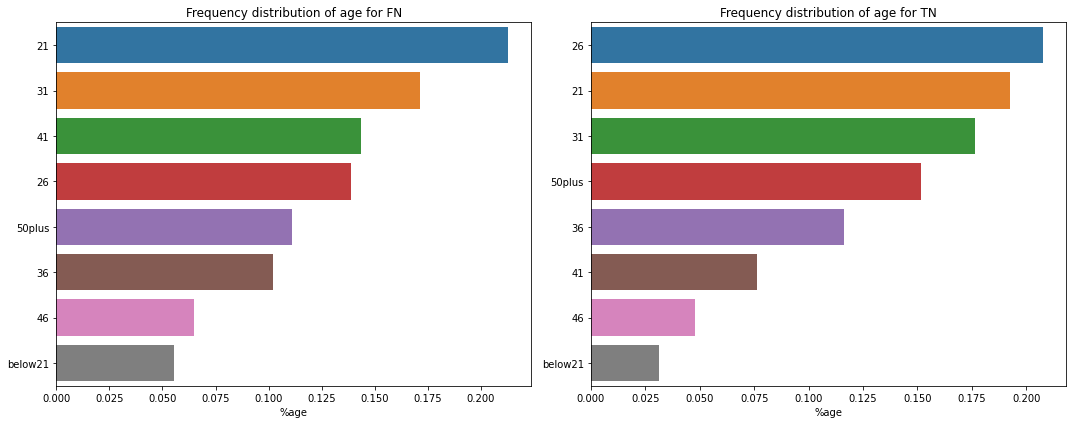

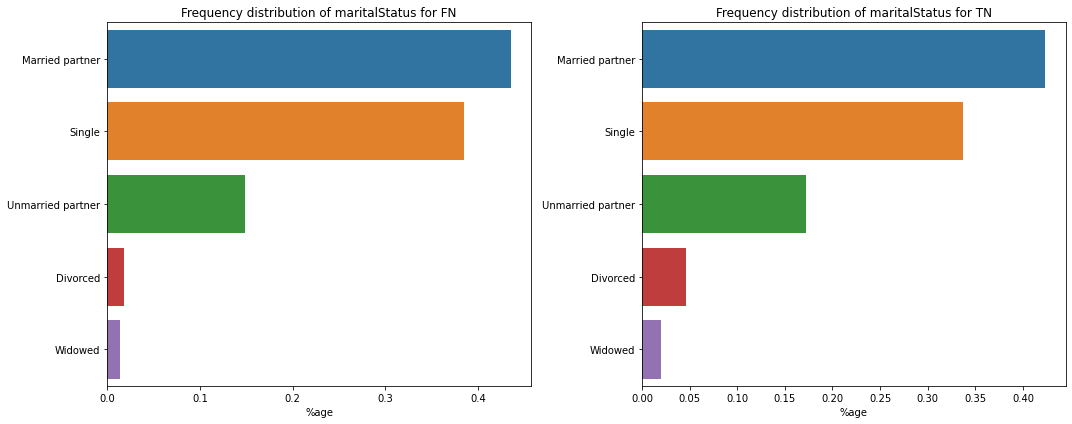

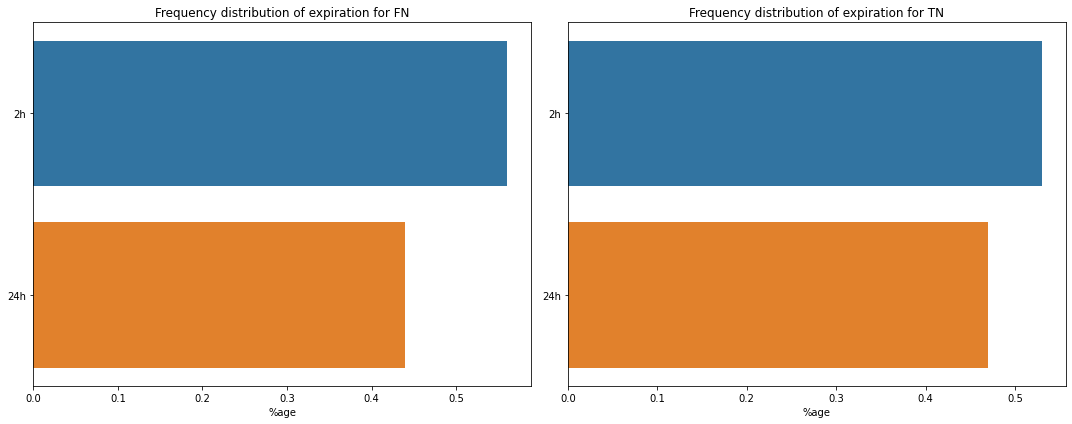

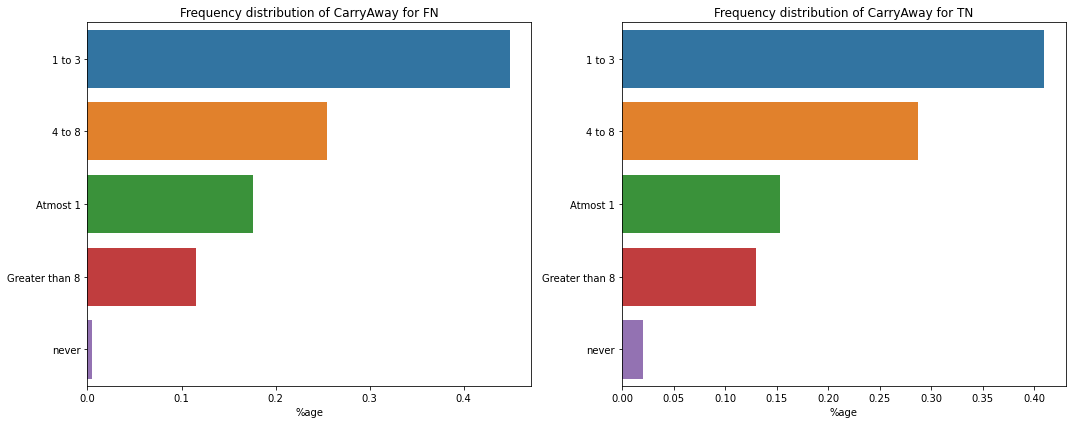

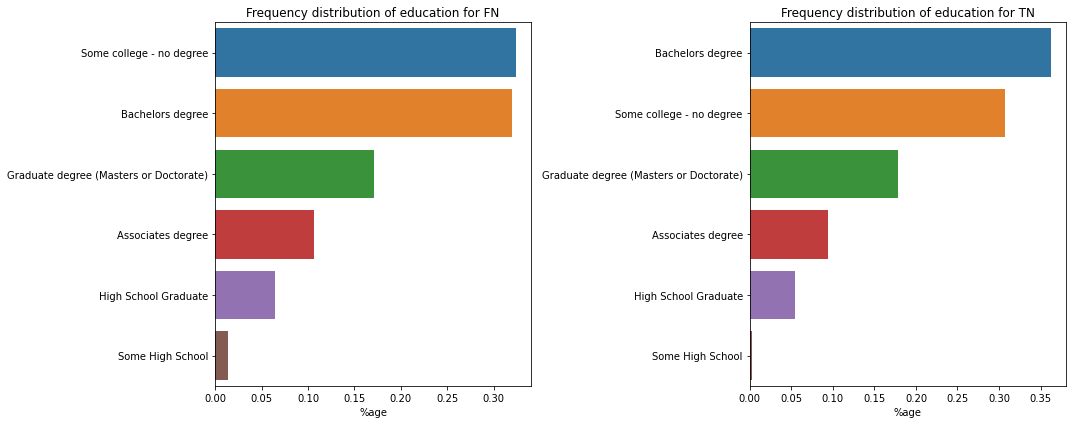

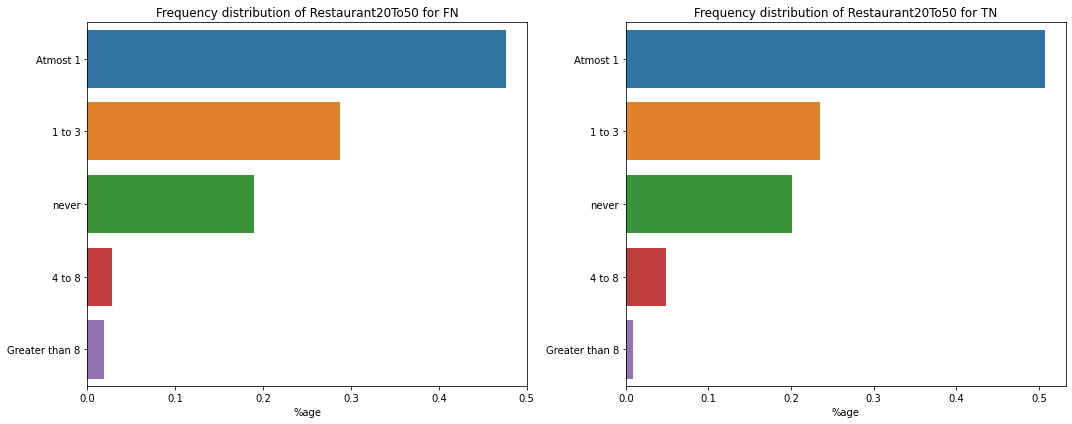

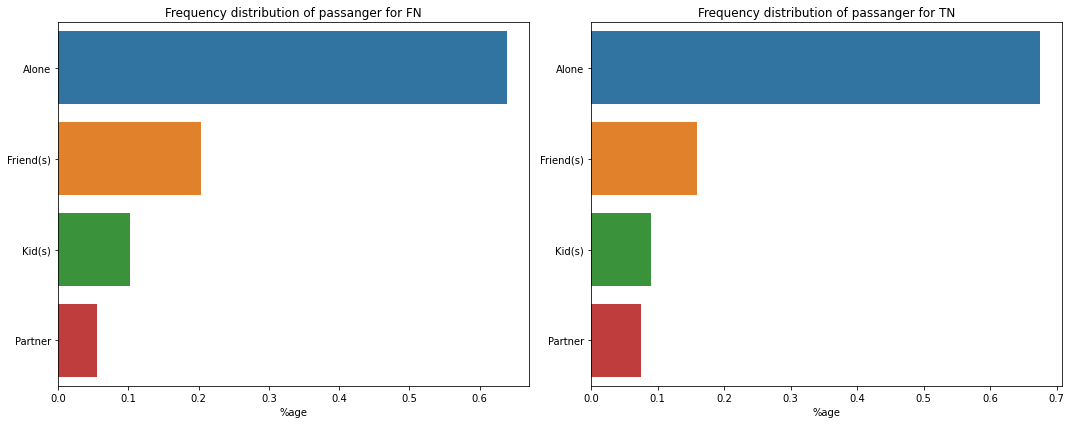

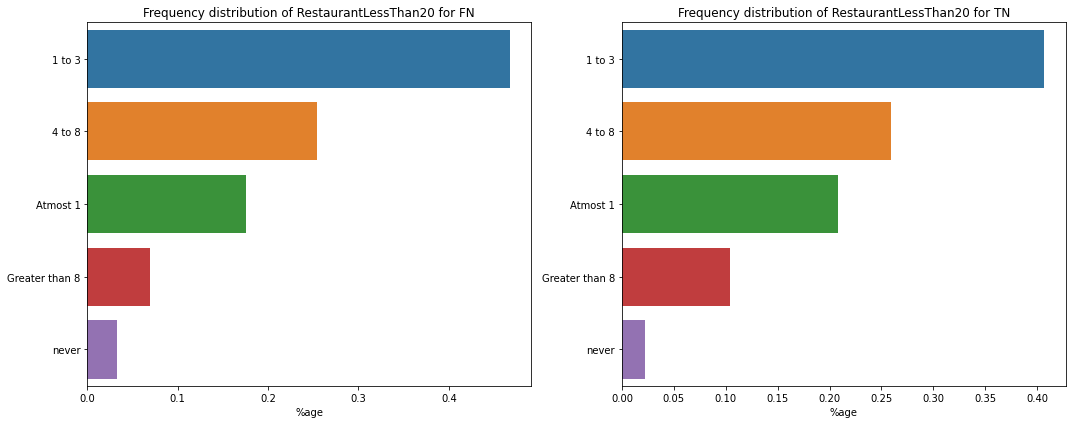

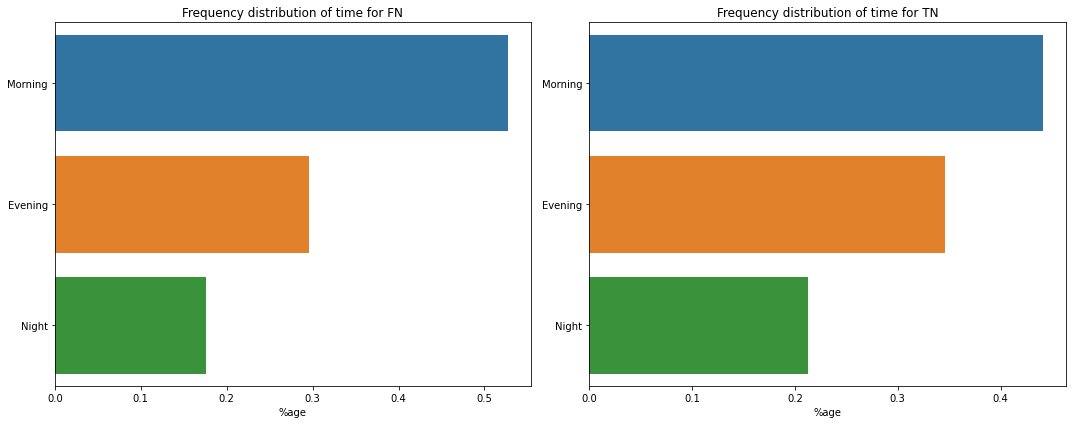

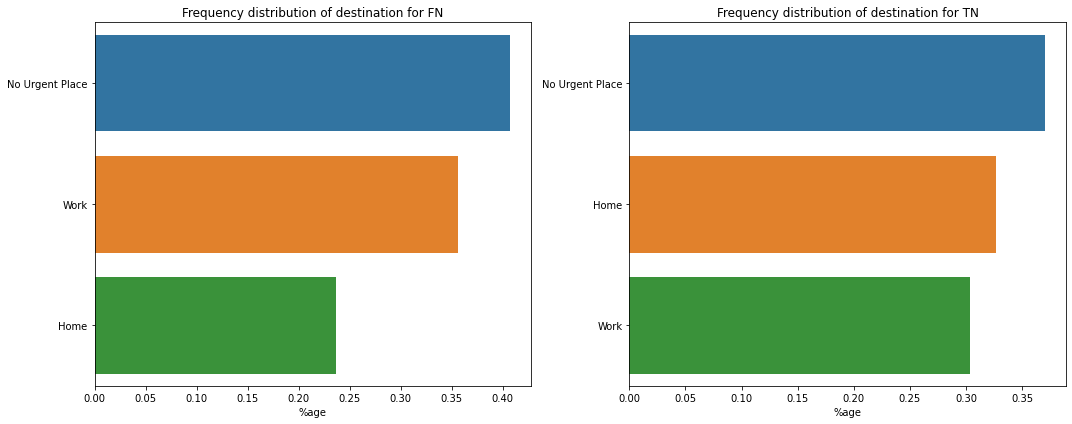

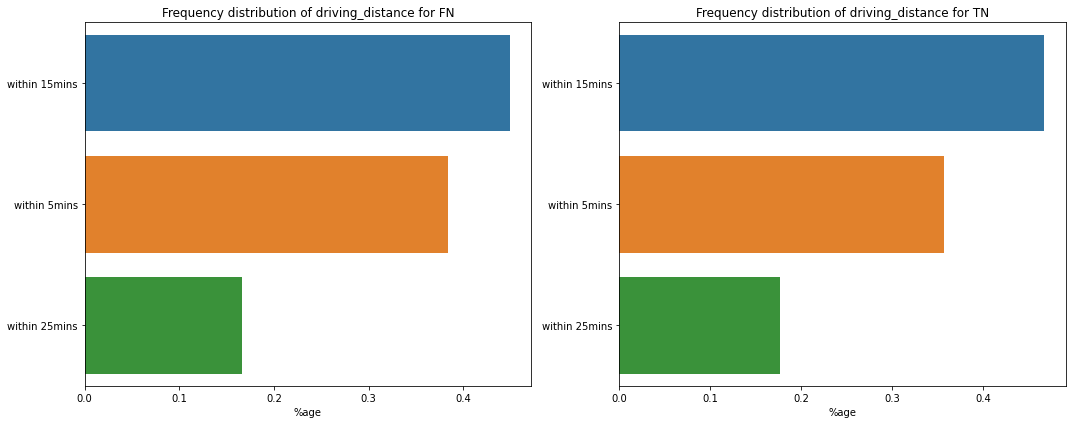

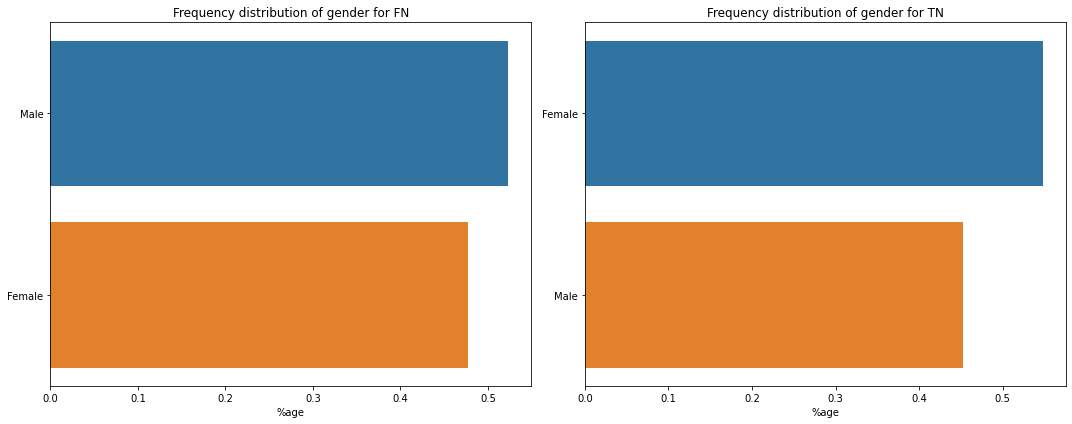

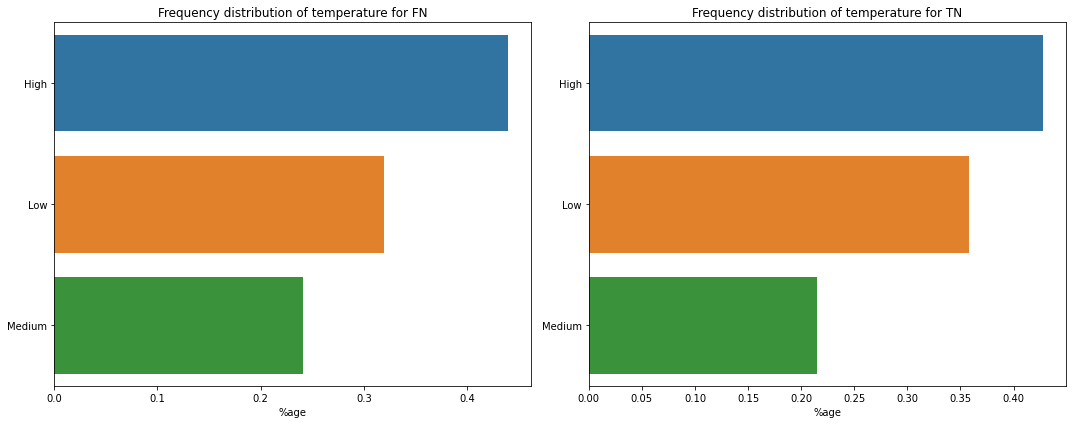

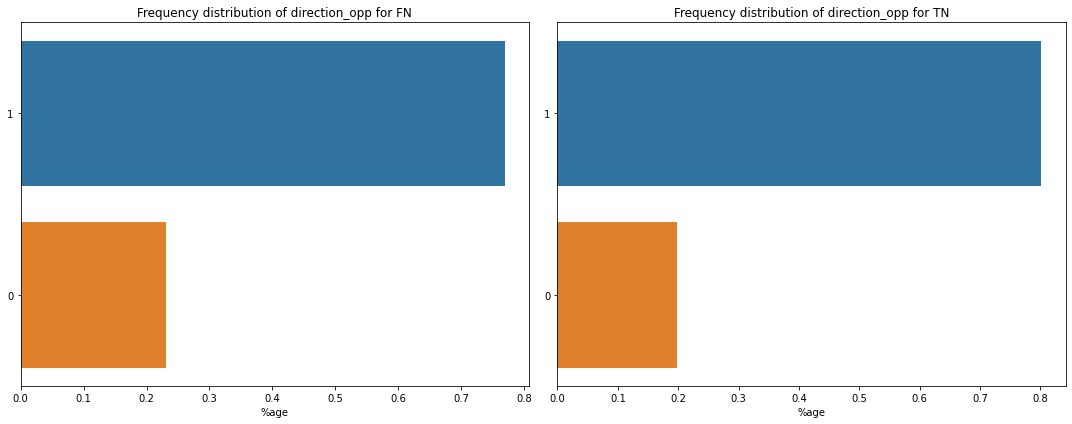

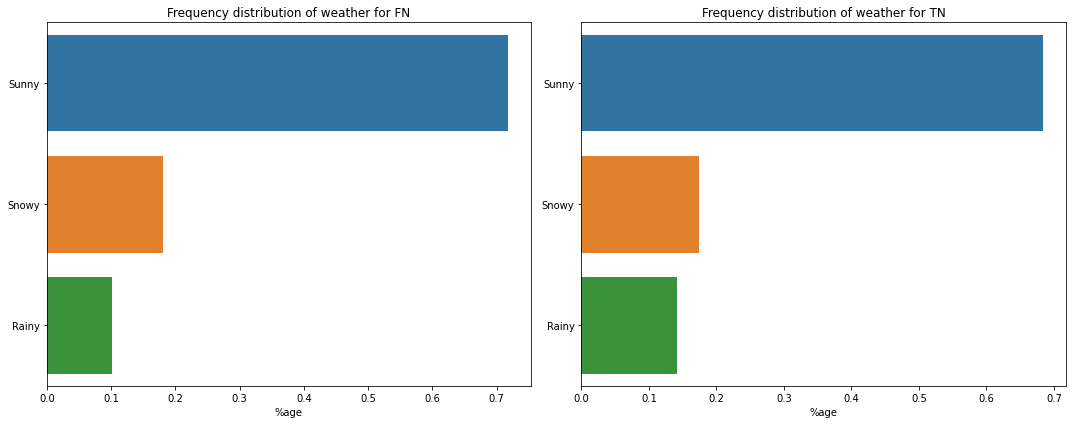

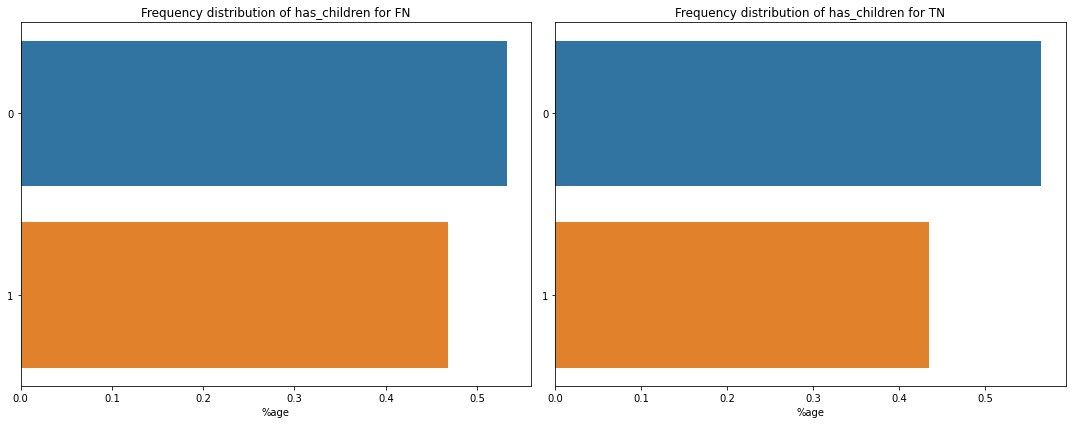

In [15]:
false_neg_pts = X_test_cb.iloc[fn,:]
true_neg_pts = X_test_cb.iloc[tn,:]

nrows = 1  
ncols = 2
figsize = (15,6)

for col in fea_imp.Column.values:
    freq_plotter(nrows,ncols,figsize,col,false_neg_pts,true_neg_pts,'neg')
    print('='*130)

Observations
* A lot of False negatives on Coffeehouse coupons, but probably due to count.
* Also more FN on points where user have work as destination and have Income-Range of \$25000-\$37499.   
This is the same trend that we saw in False-positive points. 

### Conclusion
Based on above obs. we can conclude:
* The model is predicting a lot Coffeehouse coupons as positive. 
* Even lot of FN exist for the same but that could be due to the fact that most coupons are Coffeehouse only.(as most TN are also Coffeehouse)

* We have a lot of FP where people have home as destination and a lot of FN where people have work as destination, probably because model is getting a little biased that if a person is going home then he might accept the coupons whereas if he going to work then he might reject the coupon.

Most of the categories of attributes have the the same share of True points and False points (For example :- we have a lot of FP for category 'A' and also a lot of TP also for category 'A') hence we cannot make any strong conclusions on which specific values our model is failing on. This could be due to the fact that we only have around \~ 600 FP&FN because the dataset is too small.  
Collecting more data in this case will be very helpful for both - realtime evaluation of our model and also error analysis.